This notebook aims to explore capabilities of the NNs to predict density error based on the information about the <i> density field only</i>. They are compared with deterministic parametrization from the paper (Stanley et al 2020).

# Import

In [61]:
import glob, os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
import dask
from IPython import display
from prettytable import PrettyTable
import pytorch_lightning as pl
import inspect

In [2]:
import platform
print(platform.platform())

macOS-12.4-arm64-arm-64bit


In [3]:
#device = torch.device("mps")
device = torch.device("cpu")

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:53690")

# Dataset definitions

The proposed implementation of the ``pytorch Dataset`` class reads netcdf files with data and can transform it for pytorch tensors. It allows to choose any number of netcdf files that will form the dataset and adjust the quantity of time snapshots taken from files. It also can perform normalization by mean and std of a variable in the file (so that the average is performed individually for each region and season). It is possible to create a dataset from 1 region and season, or to combine few one them (by combining files) and shuffle the snapshots in the training dataset.

In [5]:
keys_to_add_to_sample = ['sigma0_model', 'diff_sigma0_sqr', 'diff_T_sqr', 'rho_ct_ct', \
                         'sigma0_delta']

In [6]:
class SalinityTemperatureDensityDataset(torch.utils.data.Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, list_of_netcdf_files, select='All', portion_of_time_series=0.5, transform=None, normalize=False):
        self.data = [xr.DataArray() for i in range(len(list_of_netcdf_files))]
        for i, datasetNetcdfFile in enumerate(list_of_netcdf_files) :
            self.data[i] = xr.open_dataset(datasetNetcdfFile).load()
            # nan filling (very draft version of nans treatment)
            self.data[i] = self.data[i].bfill(dim='x')
            if (np.isnan(self.data[i]['diff_S_sqr']).any() or np.isnan(self.data[i]['sigma0_delta']).any()) :
                print("NANS in data " + datasetNetcdfFile)
        data_file_len = len(self.data[0]['time_counter'])
        if (select == 'All') :
            time_index_range = np.arange(0, data_file_len)
        elif (select == 'First') :
            time_index_range = np.arange(0, int(portion_of_time_series*data_file_len)+1)
        elif (select == 'Last') :
            time_index_range = np.arange(int((1-portion_of_time_series)*data_file_len), data_file_len)
        self.total_len = len(self.data)*len(time_index_range)
        self.index_table = np.transpose(np.stack([np.concatenate([np.full(len(time_index_range), i) for i in range(len(self.data))]),\
         np.concatenate([time_index_range for i in range(len(self.data))])]))
        self.transform = transform
        self.normalize = normalize
        if (normalize) :
            for i in range(len(list_of_netcdf_files)) :
                for key in self.data[i].data_vars :
                    self.data[i].attrs['mean_'+key] = self.data[i].data_vars[key].mean().compute()
                    self.data[i].attrs['std_'+key] = self.data[i].data_vars[key].std().compute()
        
    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        [index_of_dataset, index_of_time_counter] = self.index_table[idx]
        current_dataframe = self.data[index_of_dataset].isel(time_counter=index_of_time_counter).load()
        
        sample = dict()
        sample['dataset_index'] = index_of_dataset
        sample['dataset_region'] = self.data[index_of_dataset].attrs['region']
        sample['dataset_season'] = self.data[index_of_dataset].attrs['season']
        for key in keys_to_add_to_sample :
            if self.normalize :
                # normalize by substracting mean and dividing by std of the file dataset
                sample[key] = ((current_dataframe[key]-current_dataframe.attrs['mean_'+key])/current_dataframe.attrs['std_'+key]).values
                sample['mean_'+key] = current_dataframe.attrs['mean_'+key].values
                sample['std_'+key] = current_dataframe.attrs['std_'+key].values
            else : 
                sample[key] = current_dataframe[key].values

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample
        for key in keys_to_add_to_sample :
            transformed_sample[key] = torch.from_numpy(sample[key])
        return transformed_sample

# Data properties

In [8]:
list_of_datasets = sorted(glob.glob('datasets/dataset?.nc'))  # put correct path to netcdf files here
print(list_of_datasets)

['datasets/dataset0.nc', 'datasets/dataset1.nc', 'datasets/dataset2.nc', 'datasets/dataset3.nc', 'datasets/dataset4.nc', 'datasets/dataset5.nc']


In [9]:
h = 20 # height of images
w = 20 # width of images

# Useful functions

In [10]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# Fully-connected NN

In [160]:
class LitPixelModel(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        self.inputs = inputs
        self.outputs = outputs

    def training_step(self, batch, batch_idx):
        x = self.transform_input(batch, self.inputs)
        y_true = self.transform_target(batch, self.outputs)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log("loss", {"train": loss}, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = self.transform_input(batch, self.inputs)
        y_true = self.transform_target(batch, self.outputs)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log("loss", {"validation": loss}, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        #optimizer = optim.Adam(self.parameters(), lr=1e-3)
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer

    def transform_input(self, sample, inputs) :
        return torch.hstack([sample[key].view(-1,1) for key in inputs]).to(torch.float32)
    def transform_target(self, sample, outputs) : 
        return torch.hstack([sample[key].view(-1,1) for key in outputs]).to(torch.float32)

## Experiment 0

In [161]:
exps = [dict(), dict()] 

In [162]:
exps[0]['keys_input'] = {'diff_sigma0_sqr', 'sigma0_model'}
exps[0]['keys_targets'] = {'sigma0_delta'}

In [163]:
exps[0]['label'] = '2 layers'
exps[0]['model'] = torch.nn.Sequential(torch.nn.Linear(len(exps[0]['keys_input']), 16), \
                                       torch.nn.ReLU(), \
                                       torch.nn.Linear(16, len(exps[0]['keys_targets'])))

In [164]:
exps[0]['batch_size'] = 5

In [165]:
%%time
exps[0]['train_dataset'] = SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='Last', \
                                                  portion_of_time_series=0.6, transform=ToTensor(), normalize=True)
exps[0]['test_dataset'] = SalinityTemperatureDensityDataset(list_of_netcdf_files = list_of_datasets, select='First', \
                                                 portion_of_time_series=0.2, transform=ToTensor(), normalize=True)

CPU times: user 429 ms, sys: 59.1 ms, total: 488 ms
Wall time: 520 ms


In [166]:
train_data_loader = torch.utils.data.DataLoader(dataset=exps[0]['train_dataset'], batch_size=exps[0]['batch_size'], shuffle=True, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(dataset=exps[0]['test_dataset'], batch_size=exps[0]['batch_size'], drop_last=True)

In [167]:
print(r'Input data for training contains ' + str(len(train_data_loader)) + ' batches, each batch contains N*h*w=' + str(exps[0]['batch_size']*h*w) + \
      ' pixels, each pixel is represented by a tensor containg values of ' + str(len(exps[0]['keys_input'])) + ' variables: ' + str(exps[0]['keys_input']) + \
     '. Test dataset consists of ' + str(len(test_data_loader)) + ' identical batches.')

Input data for training contains 255 batches, each batch contains N*h*w=2000 pixels, each pixel is represented by a tensor containg values of 2 variables: {'diff_sigma0_sqr', 'sigma0_model'}. Test dataset consists of 86 identical batches.


In [168]:
FCNNs_2layers = LitPixelModel(exps[0]['model'], exps[0]['keys_input'], exps[0]['keys_targets'])

In [169]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=10)
trainer.fit(model=FCNNs_2layers, train_dataloaders=train_data_loader, val_dataloaders=test_data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type       | Params
---------------------------------------
0 | nnModel | Sequential | 65    
---------------------------------------
65        Trainable params
0         Non-trainable params
65        Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Convolutional NN model

In [122]:
keys_input_CNN = {'sigma0_model'}
keys_targets_CNN = {'sigma0_delta'}

In [165]:
import torch.nn as nn

class first_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(len(keys_input_CNN), 32, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate')
        self.conv5 = nn.Conv2d(64, len(keys_targets_CNN), kernel_size=3, padding='same', padding_mode='replicate')
        #self.batch_norm1 = nn.BatchNorm2d(32)
        #self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.batch_norm1(x)
        
        # conv layer 2
        x = self.conv2(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 3
        x = self.conv3(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 4 
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.batch_norm2(x)
        
        # conv layer 5 
        x = self.conv5(x)
        
        return x        

## Instantiate model  

In [166]:
modelCNN = (first_CNN()).to(torch.float32).to(device)

In [167]:
print(modelCNN)

first_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
)


In [168]:
count_parameters(modelCNN)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    288     |
|  conv1.bias  |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
| conv3.weight |   73728    |
|  conv3.bias  |    128     |
| conv4.weight |   73728    |
|  conv4.bias  |     64     |
| conv5.weight |    576     |
|  conv5.bias  |     1      |
+--------------+------------+
Total Trainable Params: 167041


167041

In [169]:
def transform_input_CNN(sample) :
    return torch.transpose(torch.stack([sample[key] for key in keys_input_CNN]), 0, 1).to(torch.float32).to(device)
def transform_target_CNN(sample) : 
    return sample['sigma0_delta'].view(batch_size, 1, h, w).to(torch.float32).to(device)

In [170]:
# Loss and Optimizer
criterion = nn.MSELoss()  # softmax is already here!
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=0.001)

## Training

Training data set size:

In [171]:
print('Input data for training contains ' + str(len(train_data_loader)) + ' batches, each batch contains ' + str(batch_size) + \
      ' instanteneous 2D maps of ' +str(len(keys_input_CNN)) + ' channels: ' + str(keys_input_CNN) + ' of size ' + str(h)+'x'+str(w) + ' pixels.')

Input data for training contains 255 batches, each batch contains 5 instanteneous 2D maps of 1 channels: {'sigma0_model'} of size 20x20 pixels.


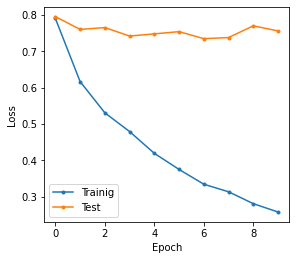

CPU times: user 1min 30s, sys: 22.3 s, total: 1min 52s
Wall time: 1min 31s


In [172]:
%%time
nb_of_epochs = 10

epoch_training_losses = np.empty(nb_of_epochs)
epoch_test_losses = np.empty(nb_of_epochs)

# Iterate through train set minibatchs
for epoch in tqdm(range(nb_of_epochs)):  
    print('Epoch ' + str(epoch))
    # Train
    training_losses = list()
    for sample in tqdm(train_data_loader, desc='Training', ascii=True):
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = transform_input_CNN(sample)
        y = modelCNN(x)
        loss = criterion(y, transform_target_CNN(sample))
        # Backward pass
        loss.backward()
        optimizer.step()
        training_losses = np.append(training_losses, loss.detach().cpu().numpy())
    epoch_training_losses[epoch] = np.mean(training_losses)
    # Test
    with torch.no_grad():
        test_losses = list()
        for sample in tqdm(test_data_loader, desc='Testing', ascii=True):
            # Forward pass
            x = transform_input_CNN(sample)
            y = modelCNN(x)

            loss = criterion(y, transform_target_CNN(sample))
            test_losses = np.append(test_losses, loss.detach().cpu().numpy())
        epoch_test_losses[epoch] = np.mean(test_losses)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3.5), constrained_layout=True)
    
    ax.plot(epoch_training_losses[0:epoch+1], '.-', label='Trainig')
    ax.plot(epoch_test_losses[0:epoch+1], '.-', label='Test')
    ax.set(yscale='linear', xlabel='Epoch', ylabel='Loss')
    ax.legend()
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    plt.show()

# Compare results with deterministic parametrization

Deterministic parametrization:

In [131]:
def determ_param(diff_T_sqr, deriv_rho_TT, c) :
    return 0.5*c*deriv_rho_TT*diff_T_sqr

Functions for normalization and restoring units in data:

In [183]:
def restore_units(sample, data, variable, index_in_batch=0) :
    return (sample['std_'+variable][index_in_batch]*data[index_in_batch]+sample['mean_'+variable][index_in_batch])
def normalize(sample, data, variable, index_in_batch=0) :
    return (data[index_in_batch]-sample['mean_'+variable][index_in_batch])/(sample['std_'+variable][index_in_batch])

In [184]:
# coefficient c in the deterministic parametrization (the one thar is calibrated)
coef_determ_param = 0.1

In [193]:
sample = test_data_iterator.next()
index_in_batch = 2

snapshot = dict()
snapshot['true_error'] = np.squeeze(restore_units(sample,sample['sigma0_delta'],'sigma0_delta',index_in_batch).numpy())
snapshot['FCNN'] = restore_units(sample, modelFCNN(transform_input(sample)).view(batch_size,w,h),'sigma0_delta',index_in_batch).detach().cpu().numpy()
snapshot['CNN'] = restore_units(sample, modelCNN(transform_input_CNN(sample)).view(batch_size,w,h),'sigma0_delta',index_in_batch).detach().cpu().numpy()
snapshot['determ_param'] = determ_param(restore_units(sample,sample['diff_T_sqr'],'diff_T_sqr',index_in_batch), \
                                        restore_units(sample,sample['rho_ct_ct'],'rho_ct_ct',index_in_batch), \
                                        coef_determ_param).numpy()

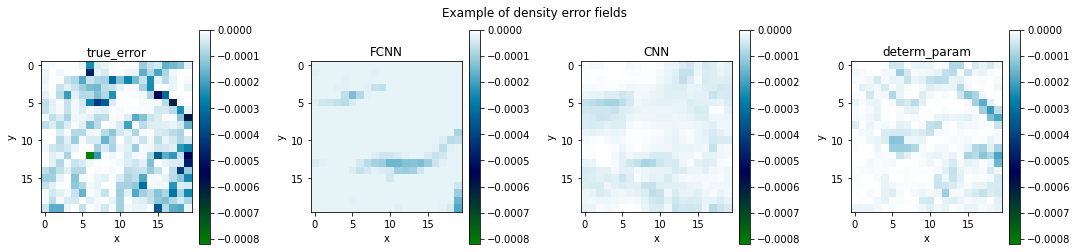

In [194]:
fig, ax = plt.subplots(ncols=len(snapshot.keys()), nrows=1, figsize=(15,3.5), constrained_layout=True)
fig.suptitle('Example of density error fields')
for i, key in enumerate(snapshot.keys()) :
    if i == 0 :
        img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
    else :
        img = ax[i].imshow(snapshot[key], cmap='ocean', vmin=color_min, vmax=color_max)
        fig.colorbar(img, ax=ax[i])
    ax[i].set(title=key, xlabel='x', ylabel='y')
plt.show()

# Evaluation

## Total MSE on a dataset

In [187]:
eval_loss = nn.MSELoss(reduction='none') 

In [188]:
MSE = dict({'determ_param': [], 'FCNN': []})
MSE['determ_param'] = [ list() for i in range(len(list_of_datasets))]
MSE['FCNN' ] = [ list() for i in range(len(list_of_datasets))]
MSE['CNN' ] = [ list() for i in range(len(list_of_datasets))]
labels = ['' for i in range(len(list_of_datasets))]

In [189]:
%%time
for i in range(len(list_of_datasets)) :
    single_dataset = SalinityTemperatureDensityDataset(list_of_netcdf_files = [list_of_datasets[i]], select='Last', \
                                                 portion_of_time_series=0.2, transform=ToTensor(), normalize=True)
    eval_data_loader = DataLoader(dataset=single_dataset, batch_size=1, shuffle=False)
    current_list_FCNN = []; current_list_CNN = []; current_list_param = []
    for j, sample in enumerate(eval_data_loader) :
        true_error = restore_units(sample,sample['sigma0_delta'],'sigma0_delta',0).view(-1,1).to(torch.float32).to(device)
        FCNN_error = restore_units(sample, modelFCNN(transform_input(sample)).view(1,w,h),'sigma0_delta',0).view(-1,1)
        CNN_error = restore_units(sample, modelCNN(transform_input_CNN(sample)).view(1,w,h),'sigma0_delta',0).view(-1,1)
        determ_param_error = determ_param(restore_units(sample,sample['diff_T_sqr'],'diff_T_sqr',0), \
                                        restore_units(sample,sample['rho_ct_ct'],'rho_ct_ct',0), \
                                        coef_determ_param).view(-1,1).to(torch.float32).to(device)
        current_list_FCNN = current_list_FCNN + list(np.squeeze(eval_loss(FCNN_error, true_error).detach().cpu().numpy()))
        current_list_CNN = current_list_CNN + list(np.squeeze(eval_loss(CNN_error, true_error).detach().cpu().numpy()))
        current_list_param = current_list_param + list(np.squeeze(eval_loss(determ_param_error, true_error).detach().cpu().numpy()))
    MSE['FCNN'][i] = current_list_FCNN
    MSE['CNN'][i] = current_list_CNN
    MSE['determ_param'][i] = current_list_param
    labels[i] = 'Reg ' + sample['dataset_region'][0] + ' ' + sample['dataset_season'][0]

CPU times: user 2.98 s, sys: 919 ms, total: 3.9 s
Wall time: 3.69 s


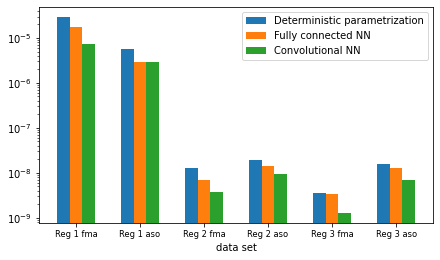

In [190]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 3.5))
#fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(len(list_of_datasets))
bar_width = 0.2

for i, key in enumerate(['determ_param', 'FCNN', 'CNN']) :
    ax.bar(x+i*bar_width, [np.mean(MSE[key][region]) for region in range(len(list_of_datasets))], width=bar_width, label=key)
ax.legend(['Deterministic parametrization', 'Fully connected NN', 'Convolutional NN'])
ax.set_xticks(x+bar_width)
#ax.axhline(y=1., color='k')
ax.set_xticklabels(labels,fontsize=10)
ax.set_xlabel('data set')
ax.xaxis.set_tick_params(labelsize='small')
ax.set(yscale='log')
plt.show()

## Histograms of MSE

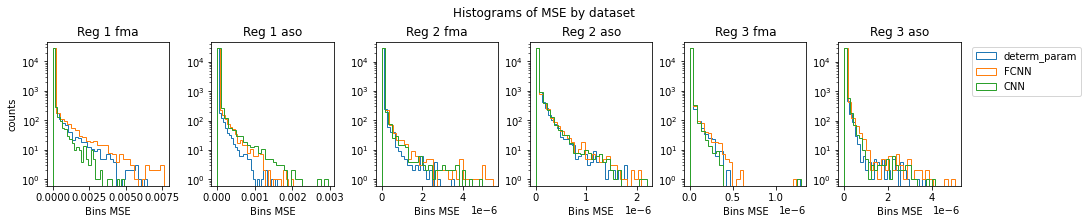

In [64]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
fig.suptitle('Histograms of MSE by dataset')
for key in ['determ_param', 'FCNN', 'CNN'] :
    for i in range(len(list_of_datasets)) :
        ax[i].hist(MSE[key][i], bins=30, histtype='step', density=False, label=key)
        ax[i].set(yscale='log', title=labels[i], xlabel='Bins MSE')
ax[0].set(ylabel='counts')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()